# Fine-tuning GPT-2 for text classification
Stefan/Yuzhao Heng
Since Wed. Feb. 9th, 2022


Reproduce the results in paper [Zero-shot Text Classification With Generative Language Models](https://arxiv.org/abs/1912.10165),
since the authors didn't release the code.

Serve as infrastructure and baseline for project on efficient and accurate encoder for text classification with many labels.


## Notebook Setup



In [8]:
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Colab Setup



In [9]:
import os
import sys


if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    ! pip3 install sty icecream transformers datasets

    # base_path = '/content/drive/My Drive//Research/'
    # os.chdir(os.path.join(base_path, 'Unified Encoder/Unified-Encoder'))

    sys.path.append(os.path.join('drive', 'My Drive', 'Research', 'Unified Encoder', 'Unified-Encoder'))


from unified_encoder.util import *
print(PATH_BASE)  # Sanity check, should be the path appended if Colab



/Users/stefanh/Documents/UMich/Research/Clarity Lab/Unified Encoder


## Setup



In [10]:
import random

import numpy as np
import torch
import transformers
from icecream import ic

from unified_encoder.baseline import gpt2


rcParams['figure.dpi'] = 200
rcParams['font.size'] = 6



## Seed setup



In [11]:
if torch.cuda.is_available():
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # Required for some CuBLAS operations
    ! echo $CUBLAS_WORKSPACE_CONFIG


seed = config('random-seed')
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)
transformers.set_seed(seed)



## Prep Model & Dataset for training


In [12]:
nm = 'debug'
model, tokenizer, data_collator = gpt2.get_model_n_tokenizer(nm)
train_args = gpt2.get_train_setup(nm)
dset_tr, dset_vl = gpt2.get_dset(
    map_func=gpt2.tokenize_func(tokenizer), remove_columns=['label', 'text'], n_sample=8, random_seed=seed
)

trainer = gpt2.CustomTrainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=dset_tr,
    eval_dataset=dset_vl,
    compute_metrics=gpt2.compute_metrics
)
cb = gpt2.MyLoggingCallback(trainer, interactive=False)
trainer.add_callback(cb)



Using custom data configuration default
Reusing dataset ag_news (/Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
Using custom data configuration default
Reusing dataset ag_news (/Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-76a45c5155a2ee95.arrow
Loading cached processed dataset at /Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-9b3097dc8e0c748c.arrow
Loading cached shuffled indices for dataset at /Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-ce92bb656b71aa1d.arrow
Loading cached shuffled indices for dataset at /Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-fb8626521cf20fea.arrow


## Train


2022-02-15 13:36:52| [GPT-2 Training]::log_update::gpt2.py:346, INFO - step=   0, epoch=  0.00, train_loss=10.6098, eval_loss=10.6355, train_acc=  0.00, eval_acc=  0.00
2022-02-15 13:36:59| [GPT-2 Training]::log_update::gpt2.py:346, INFO - step=   1, epoch=  0.50, train_loss=10.6098, eval_loss= 6.3138, train_acc=  0.00, eval_acc= 15.62
2022-02-15 13:37:04| [GPT-2 Training]::log_update::gpt2.py:346, INFO - step=   2, epoch=  1.00, train_loss= 7.6246, eval_loss= 4.4169, train_acc= 12.50, eval_acc= 15.62
2022-02-15 13:37:09| [GPT-2 Training]::log_update::gpt2.py:346, INFO - step=   3, epoch=  1.50, train_loss= 3.5232, eval_loss= 3.3659, train_acc= 18.75, eval_acc= 15.62
2022-02-15 13:37:23| [GPT-2 Training]::log_update::gpt2.py:346, INFO - step=   4, epoch=  2.00, train_loss= 5.0616, eval_loss= 2.7573, train_acc= 12.50, eval_acc= 18.75
2022-02-15 13:37:31| [GPT-2 Training]::log_update::gpt2.py:346, INFO - step=   5, epoch=  2.50, train_loss= 3.6804, eval_loss= 2.5807, train_acc= 12.50, ev

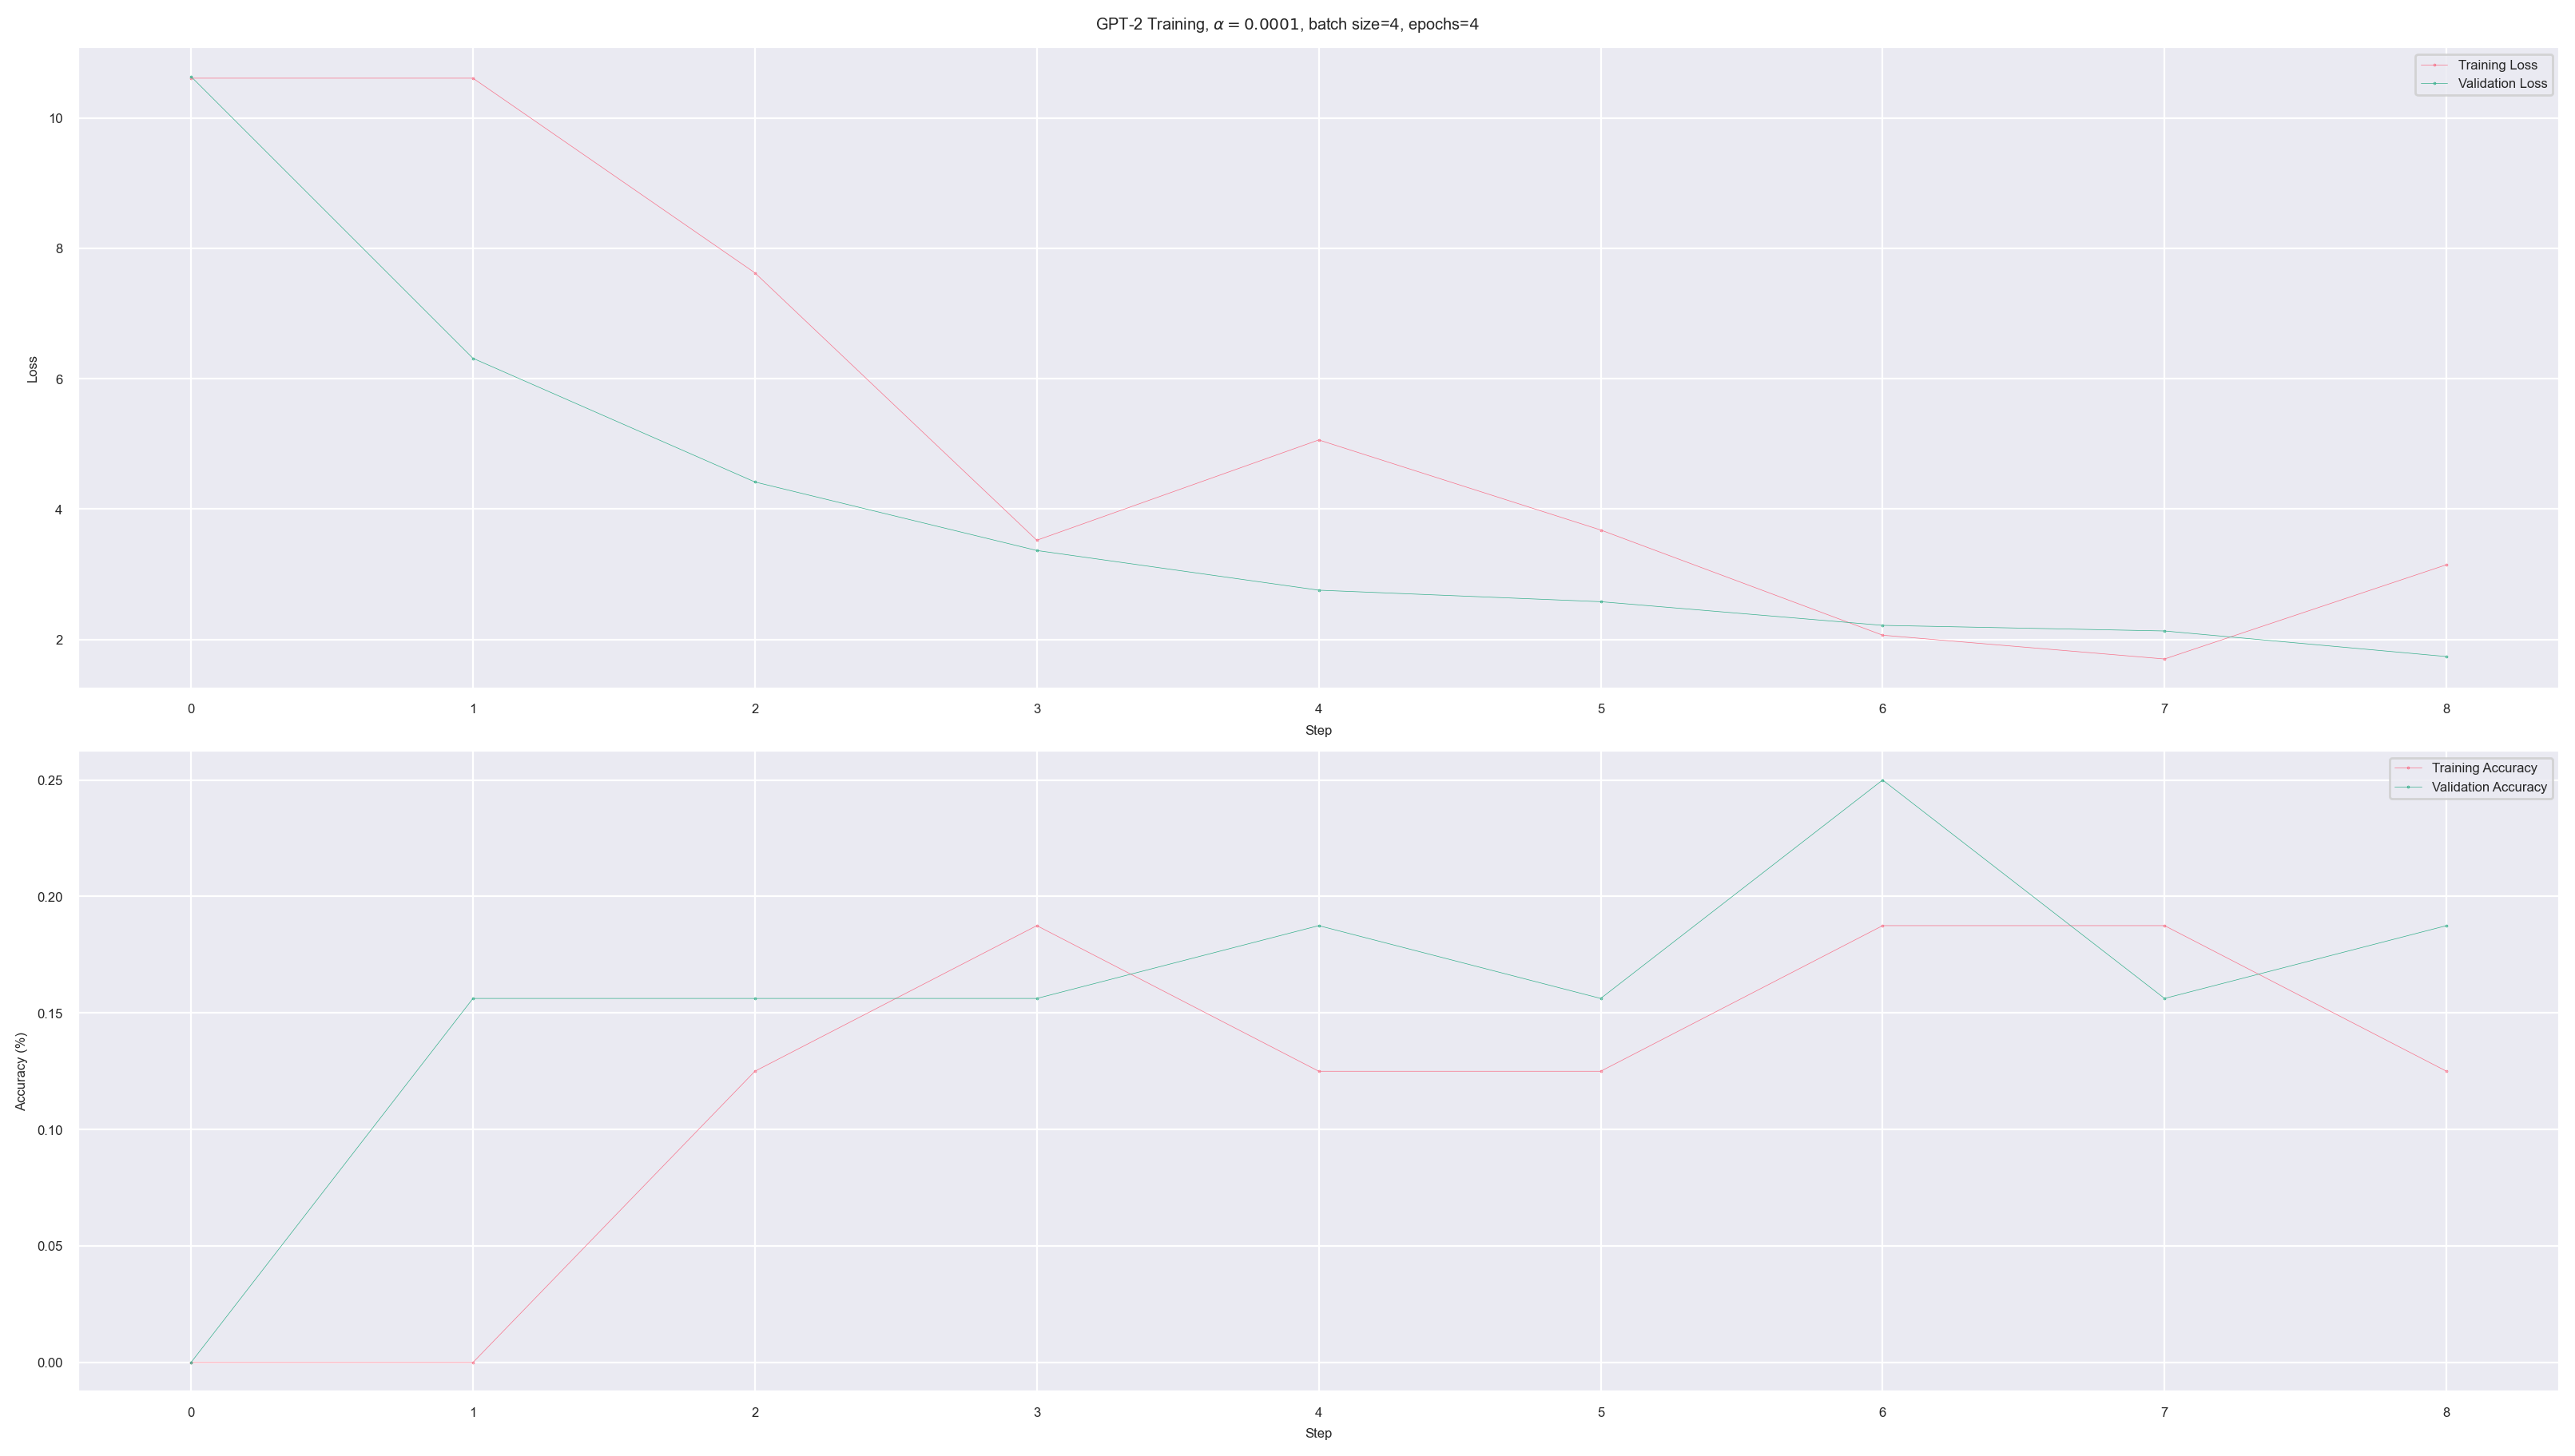

In [13]:
trainer.train()
trainer.save_model(os.path.join(trainer.args.output_dir, now(sep='-')))



## Evaluate


In [14]:
trainer.evaluate()



2022-02-15 13:38:08| [GPT-2 Training]::on_log::gpt2.py:405, INFO - {'eval_loss': 1.7392675876617432, 'eval_accuracy': 0.1875, 'eval_runtime': 0.674, 'eval_samples_per_second': 11.869, 'eval_steps_per_second': 2.967, 'epoch': 4.0}


{'eval_loss': 1.7392675876617432,
 'eval_accuracy': 0.1875,
 'eval_runtime': 0.674,
 'eval_samples_per_second': 11.869,
 'eval_steps_per_second': 2.967,
 'epoch': 4.0}